
# Setup of the environment


In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:20
🔁 Restarting kernel...


In [1]:
!conda --version

conda 4.14.0


In [22]:
!rm /usr/local/conda-meta/pinned

In [ ]:
!mamba install -q deepmd-kit=*=*gpu libdeepmd=*=*gpu lammps horovod -c https://conda.deepmodeling.com -c defaults

In [ ]:
!mamba install -q ase


## PySAGES

The next step is to install PySAGES.
First, we install the jaxlib version that matches the CUDA installation of this Colab setup. See the JAX documentation [here](https://github.com/google/jax) for more details.


In [24]:
%%bash

pip install -q --upgrade pip &> /dev/null
# Installs the wheel compatible with CUDA 11 and cuDNN 8.2 or newer.
pip install -q --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html &> /dev/null


Now we can finally install PySAGES. We clone the newest version from [here](https://github.com/SSAGESLabs/PySAGES) and build the remaining pure python dependencies and PySAGES itself.


In [25]:
%%bash

rm -rf PySAGES
git clone https://github.com/SSAGESLabs/PySAGES.git &> /dev/null
cd PySAGES
pip install -q . &> /dev/null


# DeePMD Simulation


Fisrt we define a Calculator for ASE based on DeePMD and retrieve the atoms information as well as a pre-trained DeePMD model.

In [35]:
%%bash

cd /content

PB="https://github.com/SSAGESLabs/PySAGES/raw/miccom-ws/examples/ase/deepmd/graph.pb"
XYZ="https://github.com/SSAGESLabs/PySAGES/raw/miccom-ws/examples/ase/deepmd/h2o.xyz"

wget -q $PB
wget -q $XYZ

In [36]:
from pathlib import Path
from typing import TYPE_CHECKING, Dict, List, Optional, Union

from ase.calculators.calculator import (
    Calculator, all_changes, PropertyNotImplementedError
)

from deepmd import DeepPotential

if TYPE_CHECKING:
    from ase import Atoms


class DP(Calculator):
    """Implementation of ASE deepmd calculator.

    Implemented propertie are `energy`, `forces` and `stress`

    Parameters
    ----------
    model : Union[str, Path]
        path to the model
    label : str, optional
        calculator label, by default "DP"
    type_dict : Dict[str, int], optional
        mapping of element types and their numbers, best left None and the calculator
        will infer this information from model, by default None

    Examples
    --------
    Compute potential energy

    >>> from ase import Atoms
    >>> from deepmd.calculator import DP
    >>> water = Atoms('H2O',
    >>>             positions=[(0.7601, 1.9270, 1),
    >>>                        (1.9575, 1, 1),
    >>>                        (1., 1., 1.)],
    >>>             cell=[100, 100, 100],
    >>>             calculator=DP(model="frozen_model.pb"))
    >>> print(water.get_potential_energy())
    >>> print(water.get_forces())

    Run BFGS structure optimization

    >>> from ase.optimize import BFGS
    >>> dyn = BFGS(water)
    >>> dyn.run(fmax=1e-6)
    >>> print(water.get_positions())
    """

    name = "DP"
    implemented_properties = ["energy", "free_energy", "forces", "virial", "stress"]

    def __init__(
        self,
        model: Union[str, "Path"],
        label: str = "DP",
        type_dict: Dict[str, int] = None,
        **kwargs
    ) -> None:
        Calculator.__init__(self, label=label, **kwargs)
        self.dp = DeepPotential(str(Path(model).resolve()))
        if type_dict:
            self.type_dict = type_dict
        else:
            self.type_dict = dict(
                zip(self.dp.get_type_map(), range(self.dp.get_ntypes()))
            )

    def calculate(
        self,
        atoms: Optional["Atoms"] = None,
        properties: List[str] = ["energy", "forces", "virial"],
        system_changes: List[str] = all_changes,
    ):
        """Run calculation with deepmd model.

        Parameters
        ----------
        atoms : Optional[Atoms], optional
            atoms object to run the calculation on, by default None
        properties : List[str], optional
            unused, only for function signature compatibility,
            by default ["energy", "forces", "stress"]
        system_changes : List[str], optional
            unused, only for function signature compatibility, by default all_changes
        """
        if atoms is not None:
            self.atoms = atoms.copy()

        coord = self.atoms.get_positions().reshape([1, -1])
        if sum(self.atoms.get_pbc()) > 0:
            cell = self.atoms.get_cell().reshape([1, -1])
        else:
            cell = None
        symbols = self.atoms.get_chemical_symbols()
        atype = [self.type_dict[k] for k in symbols]
        e, f, v = self.dp.eval(coords=coord, cells=cell, atom_types=atype)
        self.results['energy'] = e[0][0]
        # see https://gitlab.com/ase/ase/-/merge_requests/2485
        self.results['free_energy'] = e[0][0]
        self.results['forces'] = f[0]
        self.results['virial'] = v[0].reshape(3, 3)

        # convert virial into stress for lattice relaxation
        if "stress" in properties:
            if sum(atoms.get_pbc()) > 0:
                # the usual convention (tensile stress is positive)
                # stress = -virial / volume
                stress = -0.5 * (v[0].copy() + v[0].copy().T) / atoms.get_volume()
                # Voigt notation
                self.results['stress'] = stress.flat[[0, 4, 8, 5, 2, 1]]
            else:
                raise PropertyNotImplementedError

We then define a simulation in the same way as we would for OpenMM or HOOMD-blue

In [37]:
from ase.io import read
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.langevin import Langevin
from ase import units
from ase.io.trajectory import Trajectory
from ase import Atoms
import numpy as np
import sys
import pysages
from pysages.colvars import Distance, Angle
from pysages.methods import ABF, CVRestraints
import matplotlib.pyplot as plt


T=300.0
kT = T * units.kB
dt = 0.5 * units.fs
pi=np.pi


def wrap_system(atoms: Atoms):
    """Automatically wrap a system into the box."""
    cell = atoms.cell
    cell = cell
    for i in range(len(atoms)):
        atom = atoms[i]
        for j in range(3):
            atom.position[j]
            while atom.position[j] < 0:
                atom.position[j] += cell[j][j]
            while atom.position[j] > cell[j][j]:
                atom.position[j] -= cell[j][j]
    return atoms

  
def generate_simulation(T=T,kT=kT):
    dimer = read('h2o.xyz')
    dimer = wrap_system(dimer)
    calc = DP(model='graph.pb')
    dimer.set_calculator(calc)
    MaxwellBoltzmannDistribution(dimer, temperature_K=T)
    dyn = Langevin(dimer, dt, temperature_K=T, friction=0.02)  # 0.5 fs time step.
    def _printenergy(a=dimer):
        """Function to print the potential, kinetic and total energy"""
        epot = a.get_potential_energy() / len(a)
        ekin = a.get_kinetic_energy() / len(a)
        with open("energy.txt", "a") as f:
            print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
                'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin), file=f)

    dyn.attach(_printenergy, interval=1000)
#in case of storing ase trajectory
#    traj = Trajectory('moldyn3.traj', 'w', dimer)
#    dyn.attach(traj.write, interval=10)
    return dyn

We define some helper functions for ploting and saving the data

In [38]:
def plot_energy(result, save=True):
    fig, ax = plt.subplots()

    ax.set_xlabel("CV")
    ax.set_ylabel("Free energy $[\\epsilon]$")

    free_energy = np.asarray(result["free_energy"])
    x = np.asarray(result["mesh"])
    ax.plot(x, free_energy, color="teal")

    if save:
        fig.savefig("energy.png")
    
    return plt.show()


# %%
def plot_forces(result):
    fig, ax = plt.subplots()

    ax.set_xlabel("CV")
    ax.set_ylabel("Forces $[\\epsilon]$")

    forces = np.asarray(result["mean_force"])
    x = np.asarray(result["mesh"])
    ax.plot(x, forces, color="teal")

    fig.savefig("forces.png")


def plot_histogram(result):
    fig, ax = plt.subplots()

    ax.set_xlabel("CV")
    ax.set_ylabel("Histogram $[\\epsilon]$")

    hist = np.asarray(result["histogram"]) / np.nanmax(
        np.asarray(result["histogram"])
    )
    x = np.asarray(result["mesh"])
    ax.plot(x, hist, color="teal")

    fig.savefig("histogram.png")


# %%
def save_energy_forces(result):
    Energy = np.asarray(result["free_energy"])
    Forces = np.asarray(result["mean_force"])
    Grid = np.asarray(result["mesh"])
    hist = np.asarray(result["histogram"]) / np.nanmax(
        np.asarray(result["histogram"])
    )
    np.savetxt("FES.csv", np.column_stack([Grid, Energy]))
    np.savetxt("Forces.csv", np.column_stack([Grid, Forces]))
    np.savetxt("Histogram.csv", np.column_stack([Grid, hist]))

And finally, we define our collective variable and sampling method.

In [39]:
cvs = [
    Angle([1, 0, 2]),
]
grid = pysages.Grid(lower=(1.25,), upper=(2.5,), shape=(32,), periodic=False)
topology = (14, 4)

# Adaptive Biasing Force Method for free energy calculations
method = ABF(cvs, grid, N=100)

And run our simulation

/usr/local/lib/python3.7/site-packages/pysages/ml/utils.py:54: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  data, structure = tree_flatten(params)
/usr/local/lib/python3.7/site-packages/pysages/ml/optimizers.py:212: FutureWarning: The sym_pos argument to solve() is deprecated and will be removed in a future JAX release. Use assume_a='pos' instead.
  dp = solve(H, Je, sym_pos=True)
/usr/local/lib/python3.7/site-packages/pysages/ml/optimizers.py:212: FutureWarning: The sym_pos argument to solve() is deprecated and will be removed in a future JAX release. Use assume_a='pos' instead.
  dp = solve(H, Je, sym_pos=True)


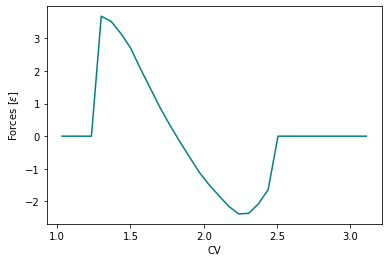

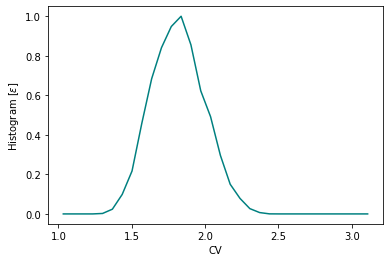

In [42]:
state = pysages.run(method, generate_simulation, 50000)
# Analyze function inside PySAGES
result = pysages.analyze(state, topology=(14, 4))
plot_forces(result)
plot_histogram(result)
save_energy_forces(result)

Let's see how the free energy surface looks like.

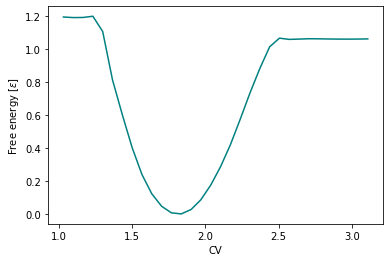

In [43]:
plot_energy(result)